In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import rqdatac as rqd
from tqdm import tqdm
from datetime import datetime
import pickle
rqd.init()


In [48]:
with open('peak_trough_factor.pkl','rb') as pf:
    close_df = pickle.load(pf)

In [60]:
trough_stock = close_df[close_df['trough']>55].reset_index(1)['order_book_id']

In [61]:
trough_stock.groupby(level=0).size()

date
2013-12-02    50
2013-12-03    52
2013-12-04    52
2013-12-05    53
2013-12-06    52
              ..
2020-08-26    71
2020-08-27    73
2020-08-28    72
2020-08-31    72
2020-09-01    74
Name: order_book_id, Length: 1648, dtype: int64

In [62]:
# with open(r'trough_stock.pkl', 'wb') as pf:
#     pickle.dump(trough_stock, pf)

In [3]:
with open(r'trough_stock.pkl', 'rb') as pf:
    trough_stock = pickle.load(pf)

In [6]:
trough_stock

date
2013-12-02    000032.XSHE
2013-12-02    000155.XSHE
2013-12-02    000158.XSHE
2013-12-02    000400.XSHE
2013-12-02    000404.XSHE
                 ...     
2020-09-01    603661.XSHG
2020-09-01    603726.XSHG
2020-09-01    603899.XSHG
2020-09-01    603909.XSHG
2020-09-01    603997.XSHG
Name: order_book_id, Length: 193632, dtype: object

# 计算得分函数

In [46]:
def cal_score(close, indicator):
    close_list = close.tolist()
    total_score = 0
    for i, price in enumerate(close_list):
        score = 1
        if i == len(close_list) - 1:
            break
        # 等差数列
        arithmetic = np.linspace(price, close_list[-1], len(close_list) - i)
        # 比较序列
        compare = close_list[i:]
        if indicator == 'peak':
            # 有大于等差数列的得分为0
            condition = np.where(compare > arithmetic, 1, 0).sum()
        elif indicator == 'trough':
            condition = np.where(compare < arithmetic, 1, 0).sum()
        if condition > 0:
            score = 0
        total_score += score
    return total_score

def visualize(daily_price, threshold, title):
    dp = daily_price.copy()
    dp['buy_signal'] = np.where(dp['trough'] >= threshold, dp['close'], np.nan)
    dp['sell_signal'] = np.where(dp['peak'] >= threshold, dp['close'], np.nan)
    plt.figure(figsize=(20, 6))
    plt.style.use('ggplot')
    plt.plot(dp.index, dp['close'], 'k-')
    plt.plot(dp.index, dp['buy_signal'], 'r.', ms=10, alpha=0.8)
    plt.plot(dp.index, dp['sell_signal'], 'gs', ms=5, alpha=0.8)
    plt.title(title, fontsize=20)

In [325]:
start = datetime.now()
start_date = '2017-01-01'
end_date = '2017-09-01'
window = 60

dates = rqd.get_trading_dates(start_date, end_date)

universe = set()
for k, v in rqd.index_components('000985.XSHG', start_date=start_date, end_date=end_date).items():
    universe = universe.union(set(v))
universe = list(universe)

In [365]:
close_df0 = rqd.get_price(lst[:], start_date=start_date, end_date=end_date, fields='close', expect_df=True)

In [366]:
close_df = close_df0.copy()
close_df.loc['002037.XSHE','close'] = 1
close_df.loc['000797.XSHE','close'] = 2
close_df.loc['002779.XSHE','close'] = 3

close_df

close
order_book_id date             
002037.XSHE   2017-01-03    1.0
              2017-01-04    1.0
              2017-01-05    1.0
              2017-01-06    1.0
              2017-01-09    1.0
...                         ...
002779.XSHE   2017-08-28    3.0
              2017-08-29    3.0
              2017-08-30    3.0
              2017-08-31    3.0
              2017-09-01    3.0

[820 rows x 1 columns]

In [367]:
# close_df['peak'] = close_df.groupby(level=0).rolling(window).apply(
#     cal_score,kwargs={'indicator': 'peak'}).values
close_df['peak'] = close_df.groupby(level=0).rolling(window).mean().values

In [368]:
close_df.groupby(level=0).apply(print)

                          close  peak
order_book_id date                   
000797.XSHE   2017-01-03    2.0   NaN
              2017-01-04    2.0   NaN
              2017-01-05    2.0   NaN
              2017-01-06    2.0   NaN
              2017-01-09    2.0   NaN
...                         ...   ...
              2017-08-28    2.0   3.0
              2017-08-29    2.0   3.0
              2017-08-30    2.0   3.0
              2017-08-31    2.0   3.0
              2017-09-01    2.0   3.0

[164 rows x 2 columns]
                          close  peak
order_book_id date                   
002037.XSHE   2017-01-03    1.0   NaN
              2017-01-04    1.0   NaN
              2017-01-05    1.0   NaN
              2017-01-06    1.0   NaN
              2017-01-09    1.0   NaN
...                         ...   ...
              2017-08-28    1.0   2.0
              2017-08-29    1.0   2.0
              2017-08-30    1.0   2.0
              2017-08-31    1.0   2.0
              2017-09-01  

""


In [247]:
lst = ['000797.XSHE','002037.XSHE','002779.XSHE','002918.XSHE','600371.XSHG','600399.XSHG','603725.XSHG']

In [187]:
close_df['trough'] = close_df['close'].groupby(level=0).rolling(window).apply(cal_score,
                                                                              kwargs={'indicator': 'trough'}).values

In [135]:
close_df['factor'] = close_df['peak'] - close_df['trough']
# close_df.dropna(inplace=True)
# with open(r'peak_trough_factor.pkl', 'wb') as pf:
#     pickle.dump(close_df, pf)
end = datetime.now()
print(end - start)

1:20:54.244822


In [243]:
close_df.index.unique()

MultiIndex([('000582.XSHE', '2017-01-03'),
            ('000582.XSHE', '2017-01-04'),
            ('000582.XSHE', '2017-01-05'),
            ('000582.XSHE', '2017-01-06'),
            ('000582.XSHE', '2017-01-09'),
            ('000582.XSHE', '2017-01-10'),
            ('000582.XSHE', '2017-01-11'),
            ('000582.XSHE', '2017-01-12'),
            ('000582.XSHE', '2017-01-13'),
            ('000582.XSHE', '2017-01-16'),
            ...
            ('002779.XSHE', '2020-08-19'),
            ('002779.XSHE', '2020-08-20'),
            ('002779.XSHE', '2020-08-21'),
            ('002779.XSHE', '2020-08-24'),
            ('002779.XSHE', '2020-08-25'),
            ('002779.XSHE', '2020-08-26'),
            ('002779.XSHE', '2020-08-27'),
            ('002779.XSHE', '2020-08-28'),
            ('002779.XSHE', '2020-08-31'),
            ('002779.XSHE', '2020-09-01')],
           names=['order_book_id', 'date'], length=8529)

In [161]:
close_df.loc[close_df.index.unique()[2]]

,close,peak
order_book_id,,
002277.XSHE,4.8802,8.0
002277.XSHE,5.0731,4.0
002277.XSHE,5.3037,9.0
002277.XSHE,5.2661,1.0
002277.XSHE,5.2990,10.0
...,...,...
002277.XSHE,4.2800,1.0
002277.XSHE,4.2800,2.0
002277.XSHE,4.3500,2.0


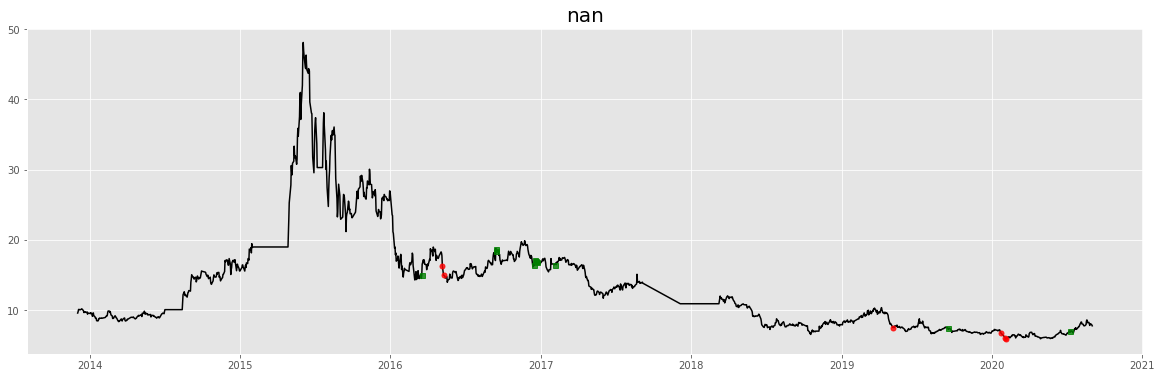

In [79]:
visualize(close_df.loc['002037.XSHE'],30,'nan')

In [102]:
df = close_df.groupby(level=0).rolling(window).apply(cal_score,kwargs={'indicator': 'peak'})

In [110]:
df.index.levels[0]

Index(['000582.XSHE', '002037.XSHE', '002277.XSHE', '603005.XSHG',
       '603725.XSHG'],
      dtype='object', name='order_book_id')